# Hands-on Day 1

## You'll learn

- familiarize with jupyter notebooks, numpy and pandas

### Input data
- efficient data format: convert CSV to Parquet
- create input vector with features for MLLib. Format of the input depends on chosen ML library

### Visualization
- explore dataset, plot features
- correlation matrix


# Dataset description

The dataset used in this example is described [here](https://archive.ics.uci.edu/ml/datasets/HIGGS). It is a binary classification problem where the goal is to train a classifier able to distinguish between a signal process, the production of new theoretical Higgs bosons, and a background process with identical decay products but distinct kinematic features.

Each row of this dataset contains 28 features plus the label:

- 21 low-level features which represent the basic measure made by the particle detector
  - Momentum of the observed paricles
  - Missing transverse momentum
  - Jets and b-tagging information
- 7 high-level features computed from the low-level features that encode the knowledge of the different intermediate states of the two processes (reconstructed invariant masses)

## Prepare the execution environment

Your code will run on a single dedicated server with 24 cores (hyperthreading enabled) and 192 GB of RAM. 
All the services needed for this tutorial are deployed as Kubernetes applications on this server. These include:
* JupytherHub
* Jupyter single-user servers
* the HDFS file-system
* Spark Clusters on demand 

#### Load custom magics definition

We load an external file implemanting some custom *magics* function. Have a look at it.

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

#### Load the Spark context

We use the custom magic *%sc* to load a pre-defined Spark context.

In [3]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 126, in run
    self.onrecv(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 143, in onrecv
    sendToFrontEnd({
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 223, in sendToFrontEnd
    monitor.send(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 57, in send
    self.comm.send(msg)
AttributeError: 'ScalaMonitor' object has no attribute 'comm'


<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-annalisagilioli>

In [4]:
# Check number of workers (executors), and cores per executor

executor_count = len(spark._jsc.sc().statusTracker().getExecutorInfos()) - 1
cores_per_executor = int(spark.getConf().get('spark.executor.cores','1'))

print('Number of executors: '+ str(executor_count))
print('Cores per executor: '+ str(cores_per_executor))

Number of executors: 5
Cores per executor: 5


## Exercise 1

### Get familiar with kubernetes commands

- You can open a terminal and use the commands: 
  - `kubectl get pods`
  - `kubectl describe pod PODNAME`
  - `kubectl get nodes`
  - `kubectl describe node NODENAME`
  - `kubectl describe farm`
  - ```kubectl logs PODNAME```
  - ```kubectl exec PODNAME -it -- /bin/bash```
  
  
- Try to stop spark with `spark.stop()`, and start it again running the cell above with a different number of workers. What happens? You can play with the number of workers, and run the cells below that execute spark commands. Provided you're getting all the workers you're asking for, does the execution time change? Try to make some scaling tests

- if you don't stop spark correctly, you will see pods in Error state. You can get rid of those by running this command:
    `kubectl get pods -n YOURUSERNAME | grep Error | awk '{print $1}' | xargs kubectl delete pod -n YOURUSERNAME`

In [5]:
!kubectl get pods

NAME                                              READY   STATUS    RESTARTS   AGE
jupyter-annalisagilioli-8c383a934920a800-exec-1   1/1     Running   0          8s
jupyter-annalisagilioli-8c383a934920a800-exec-2   1/1     Running   0          8s
jupyter-annalisagilioli-8c383a934920a800-exec-3   1/1     Running   0          8s
jupyter-annalisagilioli-8c383a934920a800-exec-4   1/1     Running   0          8s
jupyter-annalisagilioli-8c383a934920a800-exec-5   1/1     Running   0          8s


In [6]:
# !kubectl describe pod jupyter-annalisagilioli-c56e2e9344c55934-exec-1 
# !kubectl get nodes
# !kubectl describe node t2-mlwn-01.to.infn.it
!kubectl get farm

error: the server doesn't have a resource type "farm"


In [7]:
#spark.stop()

## Exercise 2

### Create parquet files, which are faster to read than CSV

- create a parquet file for all input files, you will need them for the next notebooks
- check you can read in all parquet files and that they have the correct number of events

In [8]:
# read input file
inputFile = 'file:///data-corso/Higgs100k.csv'
#inputFile = 'file:///data-corso/Higgs1M.csv'
#inputFile = 'file:///data-corso/Higgs10M.csv'

%time df = spark_session.read.format('csv').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 2.75 ms, sys: 5.69 ms, total: 8.45 ms
Wall time: 10.5 s


In [9]:
df.head()

Row(label=1.0, lepton_pT=0.869293212890625, lepton_eta=-0.6350818276405334, lepton_phi=0.22569026052951813, missing_energy_magnitude=0.327470064163208, missing_energy_phi=-0.6899932026863098, jet1_pt=0.7542022466659546, jet1_eta=-0.24857313930988312, jet1_phi=-1.0920639038085938, jet1_b-tag=0.0, jet2_pt=1.3749921321868896, jet2_eta=-0.6536741852760315, jet2_phi=0.9303491115570068, jet2_b-tag=1.1074360609054565, jet3_pt=1.138904333114624, jet3_eta=-1.5781983137130737, jet3_phi=-1.046985387802124, jet3_b-tag=0.0, jet4_pt=0.657929539680481, je4_eta=-0.010454569943249226, jet4_phi=-0.0457671694457531, jet4_b-tag=3.101961374282837, m_jj=1.353760004043579, m_jjj=0.9795631170272827, m_lv=0.978076159954071, m_jlv=0.9200048446655273, m_bb=0.7216574549674988, m_wbb=0.9887509346008301, m_wwbb=0.8766783475875854)

In [10]:
#write parquet in your home
outputFile = 'file:///home/jovyan/Higgs100k.parquet'
#outputFile = 'file:///home/jovyan/Higgs1M.parquet'
#outputFile = 'file:///home/jovyan/Higgs10M.parquet'

df.write.parquet(outputFile, mode='overwrite')

### Read in parquet files

how much faster is it to read parquet files rather than csv?

In [11]:
inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 2.97 ms, sys: 3.07 ms, total: 6.04 ms
Wall time: 518 ms


In [12]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(df.rdd.getNumPartitions()))
print("Partitioner: {}".format(df.rdd.partitioner))

Number of partitions: 18
Partitioner: None


# Now let's have a look at the input data

In [13]:
%time total_events = df.count()

print('There are '+str(total_events)+' events')

CPU times: user 2.55 ms, sys: 490 µs, total: 3.04 ms
Wall time: 1.16 s
There are 99999 events


In [14]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

## Exercise 3

- Create a function that makes a plot of any of the above variable for signal versus background (using the label variable to discriminate)
  - see an example of the plot in the hands-on slides
  - the function should take as input the dataframe *df* and the variable name. For example `plotSignalvsBg(df, 'm_bb')`
  - to develop the code, use the 100k dataset, so that debugging goes quicker
- try to plot a few input variables and try to understand which ones are more promising to distinguish signal from background  

In [15]:
# %load custom_functions.py
#!/usr/bin/env python

from pyspark.ml.feature import VectorAssembler
import numpy as np
import matplotlib.pyplot as plt 

# create a plot of the invariant mass distribution
def plotSignalvsBg(df, variable):

    ## hist is a tuple containing bins and counts foreach bin
    hist_signal, hist_bkg = compute_hist(data=df, feature=variable, target='label', n_bins=50, x_lim=[0,3])

    f, ax = plt.subplots()
    ax.hist(hist_signal[0][:-1], bins=hist_signal[0], weights=hist_signal[1], alpha=0.5, label='signal')
    ax.hist(hist_bkg[0][:-1], bins=hist_bkg[0], weights=hist_bkg[1], alpha=0.5, label='background')
    ax.set_xlabel(variable)
    ax.set_ylabel('counts')
    ax.set_title("Distribution of "+variable)
    ax.legend()
    plt.show()
    f.savefig("SignalvsBackground.pdf", bbox_inches='tight')
    return

def plotSignalvsBgWithPrediction(df, pred_full, variable):
    
    ## hist is a tuple containing bins and counts foreach bin
    hist_signal, hist_bkg = compute_hist(data=df, feature=variable, target='label', n_bins=50, x_lim=[0,3])

    hist_signal_pred, hist_bkg_pred = compute_hist(data=pred_full,
                                               feature=variable, target='prediction',
                                               n_bins=50, x_lim=[0,3])

    hist_signal_pred, hist_bkg_pred = compute_hist(data=pred_full,
                                               feature=variable, target='prediction',
                                               n_bins=50, x_lim=[0,3])
    
    f, ax = plt.subplots()
    ax.hist(hist_signal[0][:-1], bins=hist_signal[0], weights=hist_signal[1],
        alpha=0.5, label='signal')
    ax.hist(hist_bkg[0][:-1], bins=hist_bkg[0], weights=hist_bkg[1],
        alpha=0.5, label='background')

    ax.hist(hist_signal_pred[0][:-1], bins=hist_signal_pred[0], weights=hist_signal_pred[1],
        label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2)
    ax.hist(hist_bkg_pred[0][:-1], bins=hist_bkg_pred[0], weights=hist_bkg_pred[1],
        label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2)

    ax.set_xlabel(variable)
    ax.set_ylabel('counts')
    ax.legend()
    ax.set_title("Distribution of "+variable)
    plt.show()
    f.savefig("SignalvsBackgroundPred.pdf", bbox_inches='tight')
    
    return

# for Keras
def plotSignalvsBgWithPrediction2(x_test, y_test, y_pred, variable):
    
    def isSignal(x, y):
        if (y>=0.5):
            return x
        else: 
            return -1.
    
    def isBackground(x, y):
        if (y<0.5):
            return x
        else: 
            return -1.
    
    isSignalNP = np.vectorize(isSignal)
    isBackgroundNP = np.vectorize(isBackground)

    x_signal = isSignalNP(x_test, y_test)
    x_background = isBackgroundNP(x_test, y_test)
    x_signal_pred = isSignalNP(x_test, y_pred[:,0])
    x_background_pred = isBackgroundNP(x_test, y_pred[:,0])

    f, ax = plt.subplots()
    plt.hist(x_signal, bins = 100, range=[0, 3.5], alpha=0.5, label='signal') 
    plt.hist(x_background, bins = 100, range=[0, 3.5], alpha=0.5, label='background') 
    plt.hist(x_signal_pred, bins = 100, range=[0, 3.5], label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2) 
    plt.hist(x_background_pred, bins = 100, range=[0, 3.5], label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2) 
    
    plt.title("histogram") 
    ax.set_xlabel(variable)
    ax.set_ylabel('counts')
    ax.legend()
    ax.set_title("Distribution of "+variable)
    plt.show()
    f.savefig("SignalvsBackgroundPred.pdf", bbox_inches='tight')

    return

#for signal vs background plot
def compute_hist(data, feature, target='label', n_bins=100, x_lim=[0,3]):
        
    from pyspark.sql.functions import col
    
    ## Fix the range
    data = data.where((col(feature)<=x_lim[1]) &
                      (col(feature)>=x_lim[0]))
    
    sgn = data.where(col(target)==1.0) 
    bkg = data.where(col(target)==0.0)

    ## Compute the histograms
    bins_sgn, counts_sgn = sgn.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    bins_bkg, counts_bkg = bkg.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    
    return (bins_sgn, counts_sgn), (bins_bkg, counts_bkg)

def plotCorrelation(train, feature): #correlation matrix

    from pyspark.ml.stat import Correlation

    matrix = Correlation.corr(train.select('features'), 'features')
    matrix_np = matrix.collect()[0]["pearson({})".format('features')].values

    import seaborn as sns

    matrix_np = matrix_np.reshape(len(feature),len(feature))

    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.heatmap(matrix_np, cmap="YlGnBu")
    ax.xaxis.set_ticklabels(feature, rotation=270)
    ax.yaxis.set_ticklabels(feature, rotation=0)
    ax.set_title("Correlation Matrix")
    plt.tight_layout()
    plt.show()
    fig.savefig("CorrMatrix.pdf", bbox_inches='tight')
    return

def prepareData(df, split):
    train, test = df.randomSplit([1.-split,split])

    #print('Events for training {}'.format(train.count()))
    #print('Events for validation {}'.format(test.count()))
    
    feature = train.columns
    feature.remove('label')

    #VectorAssembler is a transformer that combines a given list of columns into a single vector column
    assembler = VectorAssembler(inputCols=feature, outputCol='features')
    train = assembler.transform(train)
    test = assembler.transform(test)

    X_train = train.select('features')
    Y_train = train.select('label')
    X_test = test.select('features')
    Y_test = test.select('label')
   
    #newTrain.printSchema()
    
    # need to convert DF to Pandas to use keras
    X_train_2P = X_train.toPandas()
    X_test_2P = X_test.toPandas()
    Y_train_2P = Y_train.toPandas()
    Y_test_2P = Y_test.toPandas()
    
    #X_train_2P.info()

    X = np.array(X_train_2P['features'].tolist())
    y = np.array(Y_train_2P['label'].tolist())

    X_test = np.array(X_test_2P['features'].tolist())
    y_test = np.array(Y_test_2P['label'].tolist())
    
    return X, y, X_test, y_test


# Plot variable (loss, acc) vs. epoch
def plotVsEpoch(history, variable):

    #get_ipython().run_line_magic('matplotlib', 'notebook')
    
    plt.figure()
    plt.plot(history.history[variable], label='train')
    plt.plot(history.history['val_'+variable], label='validation')
    plt.ylabel(variable)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    return

# Draw roc curve for Keras
def drawROC2(y_true, y_pred):

    from sklearn.metrics import auc, roc_curve
    fpr, tpr, threshold = roc_curve(y_score=y_pred, y_true=y_true)
    auc = auc(fpr, tpr)

    f = plt.figure()
    plt.plot([0,1], [0,1], '--', color='orange')
    plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.grid()    
    plt.show()
    f.savefig("AUC.pdf", bbox_inches='tight')
    
    return

# Draw roc curve
def drawROC(result):

    result_pd = result.select(['label', 'prediction', 'probability']).toPandas()

    result_pd['probability'] = result_pd['probability'].map(lambda x: list(x))
    result_pd['encoded_label'] = result_pd['label'].map(lambda x: np.eye(2)[int(x)])

    y_pred = np.array(result_pd['probability'].tolist())
    y_true = np.array(result_pd['encoded_label'].tolist())    
    
    drawROC2(y_true[:,0], y_pred[:,0])
    
    return

# Draw feature importance (only GBT models)
def drawFeatures(feature, model):
    fig, ax = plt.subplots(figsize=(8,10))
    ax.barh(range(28), model.featureImportances.toArray())
    ax.set_yticks(range(28))
    ax.set_yticklabels(feature)
    ax.set_xlabel('Importances')
    ax.set_title('Feature importance')
    plt.tight_layout()
    plt.show()
    
    return

def printMetrics(evaluator, prediction):

    auc = evaluator.evaluate(prediction, {evaluator.metricName: 'areaUnderROC'})
    print('AUC: %0.3f' % auc)
    # compute TN, TP, FN, and FP
    prediction.groupBy('label', 'prediction').count().show()

    # Calculate the elements of the confusion matrix
    TN = prediction.filter('prediction = 0 AND label = prediction').count()
    TP = prediction.filter('prediction = 1 AND label = prediction').count()
    FN = prediction.filter('prediction = 0 AND label <> prediction').count()
    FP = prediction.filter('prediction = 1 AND label <> prediction').count()

    # calculate accuracy, precision, recall, and F1-score
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)
    print('n precision: %0.3f' % precision)
    print('n recall: %0.3f' % recall)
    print('n accuracy: %0.3f' % accuracy)
    print('n F1 score: %0.3f' % F)
    
    return

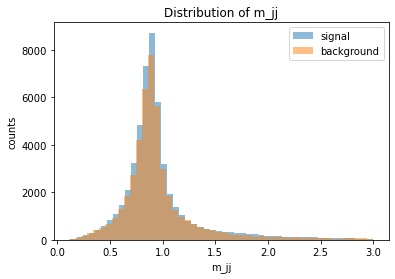

In [16]:
# |-- m_jj: double (nullable = true)
# |-- m_jjj: double (nullable = true)
# |-- m_lv: double (nullable = true)
# |-- m_jlv: double (nullable = true)
# |-- m_bb: double (nullable = true)
# |-- m_wbb: double (nullable = true)
# |-- m_wwbb: double (nullable = true
plotSignalvsBg(df, 'm_jj')


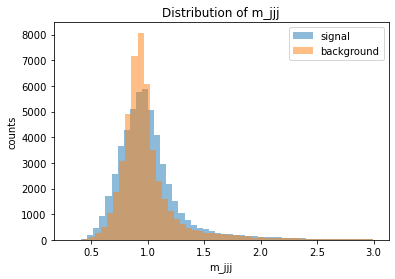

In [17]:
plotSignalvsBg(df, 'm_jjj')

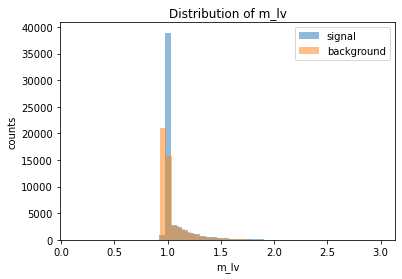

In [18]:
plotSignalvsBg(df, 'm_lv')

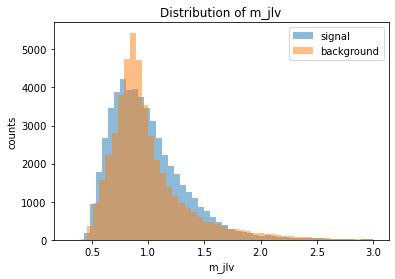

In [19]:
plotSignalvsBg(df, 'm_jlv')

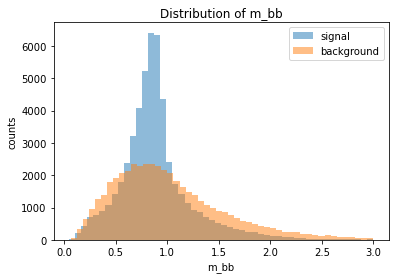

In [20]:
plotSignalvsBg(df, 'm_bb')

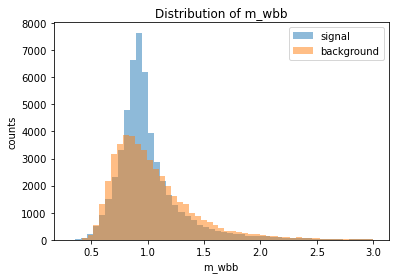

In [21]:
plotSignalvsBg(df, 'm_wbb')

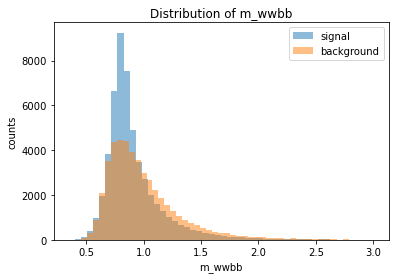

In [22]:
plotSignalvsBg(df, 'm_wwbb')

In [23]:
# Best varibles to determine the signal: m_lv, m_bb, m_wbb, m_wwbb

## Exercise 4 - Bonus

### Create the input feature vector

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe df a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer

In [24]:
feature = df.columns
first_element = feature.pop(0)

In [25]:
feature

['lepton_pT',
 'lepton_eta',
 'lepton_phi',
 'missing_energy_magnitude',
 'missing_energy_phi',
 'jet1_pt',
 'jet1_eta',
 'jet1_phi',
 'jet1_b-tag',
 'jet2_pt',
 'jet2_eta',
 'jet2_phi',
 'jet2_b-tag',
 'jet3_pt',
 'jet3_eta',
 'jet3_phi',
 'jet3_b-tag',
 'jet4_pt',
 'je4_eta',
 'jet4_phi',
 'jet4_b-tag',
 'm_jj',
 'm_jjj',
 'm_lv',
 'm_jlv',
 'm_bb',
 'm_wbb',
 'm_wwbb']

In [26]:
assembler = VectorAssembler(
    inputCols=feature,
    outputCol="features")

output = assembler.transform(df)
output.show(truncate=True)

+-----+-------------------+--------------------+-------------------+------------------------+--------------------+-------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+-----------------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|label|          lepton_pT|          lepton_eta|         lepton_phi|missing_energy_magnitude|  missing_energy_phi|            jet1_pt|            jet1_eta|            jet1_phi|        jet1_b-tag|           jet2_pt|            jet2_eta|            jet2_phi|       jet2_b-tag|            jet3_pt|            jet3_eta|            jet3_phi|        jet3_b-tag|            jet4_pt|             je4_eta|            

In [27]:
display(output)
output.select('features').take(1)

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([1.788, 0.7684, 0.9809, 0.7673, -0.4854, 1.869, 0.4792, 1.3772, 2.1731, 1.9358, -0.3545, -0.7437, 0.0, 1.954, -0.8919, -0.3186, 2.5482, 0.5097, -1.0756, 0.956, 0.0, 1.4347, 1.1137, 1.5721, 1.3062, 3.046, 1.7441, 1.5477]))]

## Exercise 5 - Bonus

Print (or draw) the correlation matrix (a table showing correlation coefficients between variables)

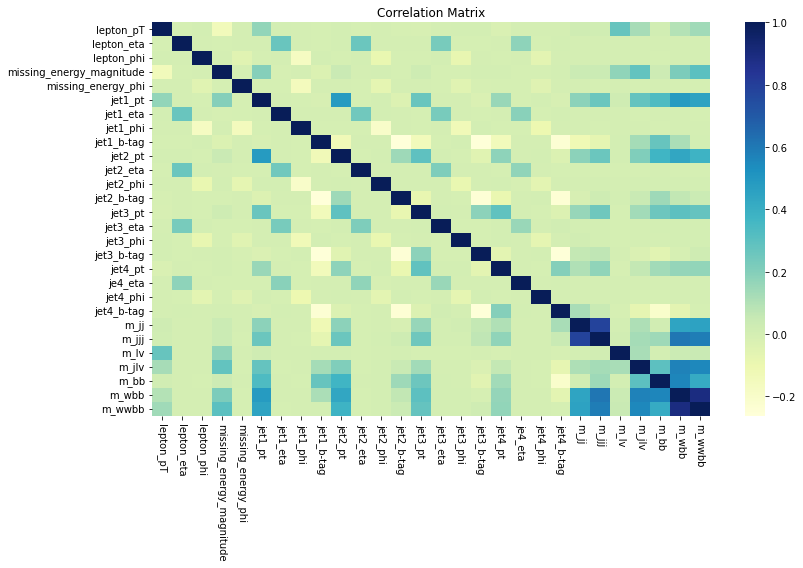

In [28]:
plotCorrelation(output,feature)

#### when you're done, stop spark, this will release the resources you're using

In [31]:
spark.stop()

In [32]:
!kubectl get pods

No resources found in annalisagilioli namespace.
